In [1]:
%load_ext autoreload
%autoreload 2

## 0. Available Datasets

These are the datasets to train:
- https://huggingface.co/datasets/nelsntk/mtg-data ~ 45K : Synthetic, scraped, glossary of terms and rules
- https://huggingface.co/datasets/jakeboggs/MTG-Eval ~80K: Synthetic: Cards, rules and interactions like combos
- https://huggingface.co/datasets/RiverTest/MTGNewChat ~ 7K. There is no more info but it seems to be synthetic
- https://huggingface.co/datasets/RiverTest/Testmtg ~ 6.5K:  Simple questions
- https://huggingface.co/datasets/TrevorJS/mtg-rules-qa ~23K: This is interesting because contains one correct and one incorrect responses
- https://www.reddit.com/r/mtgjudge/ until 2023 ~ 12.8K I downloaded and filter all posts from this subreddit to obtain QA pairs
- https://rulesguru.net/ ~ 1.5 I have already downloaded all of them and want to use them as test, for the judge LLM

This is not for training but can be use for RAG:
- https://huggingface.co/datasets/TrevorJS/mtg-rules-dataset Each rule split by section and number
- https://mtgjson.com/data-models/card/card-atomic/ Each card in JSON format. I have an script to convert this dictionaries to plain text

Another options to consider to scrape:
- https://www.mtgsalvation.com/forums/magic-fundamentals/magic-rulings Forum of rules questions
- https://www.reddit.com/r/askajudge/ Another reddit QA

## 1. Data Preprocessing

<Axes: >

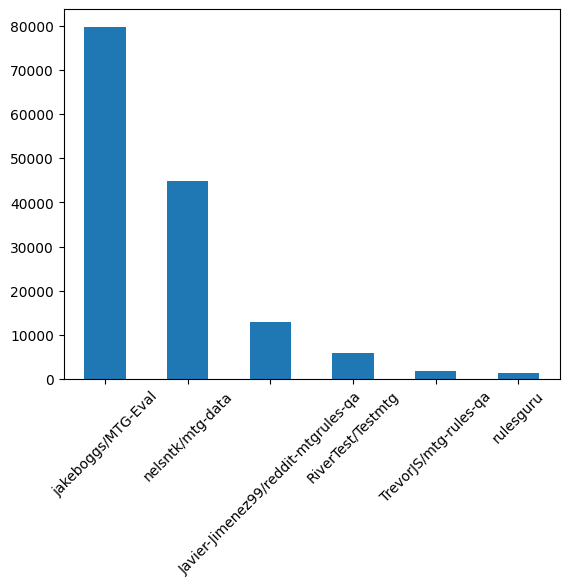

In [2]:
from gatherer_sage.dataset import generate_full_corpus

full_ds = generate_full_corpus()
full_ds["dataset_name"].value_counts().plot.bar(rot=45, xlabel="")

## 2. Embedding & Projection

In [3]:
from sentence_transformers import SentenceTransformer

embedding_model = "mixedbread-ai/mxbai-embed-large-v1"

model = SentenceTransformer(embedding_model)

embeddings = model.encode(
    full_ds["prompt"].tolist(), batch_size=512, show_progress_bar=True
)

full_ds["embeddings"] = [embeddings[i] for i in range(embeddings.shape[0])]

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/287 [00:00<?, ?it/s]

## 3. Plotting

In [4]:
import pacmap

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)
projections = embedding_projector.fit_transform(embeddings, init="pca")

full_ds["projections"] = [projections[i] for i in range(projections.shape[0])]

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.10/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [5]:
from sklearn.cluster import KMeans

num_clusters = 6
classification = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(embeddings)
full_ds["kmeans_classification"] = classification

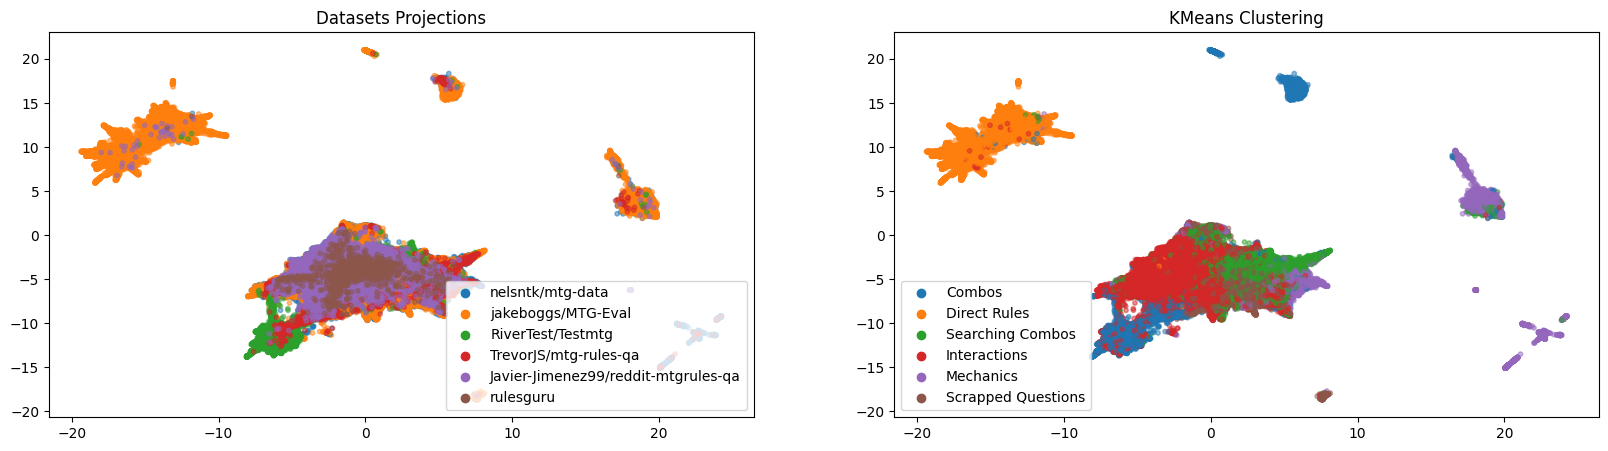

In [6]:
import matplotlib.pyplot as plt

colors = {
    "nelsntk/mtg-data": "tab:blue",
    "jakeboggs/MTG-Eval": "tab:orange",
    "RiverTest/Testmtg": "tab:green",
    "TrevorJS/mtg-rules-qa": "tab:red",
    "Javier-Jimenez99/reddit-mtgrules-qa": "tab:purple",
    "rulesguru": "tab:brown",
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.scatter(
    projections[:, 0],
    projections[:, 1],
    alpha=0.5,
    color=[colors[c] for c in full_ds["dataset_name"]],
    s=10,
)

# Create legends
for dataset_name, color in colors.items():
    ax1.scatter([], [], color=color, label=dataset_name)

ax1.legend()
ax1.set_title("Datasets Projections")


kmeans_colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:cyan",
]
ax2.scatter(
    projections[:, 0],
    projections[:, 1],
    alpha=0.5,
    color=[kmeans_colors[c] for c in full_ds["kmeans_classification"]],
    s=10,
)
ax2.set_title("KMeans Clustering")

kmeans_titles = [
    "Combos",
    "Direct Rules",
    "Searching Combos",
    "Interactions",
    "Mechanics",
    "Scrapped Questions",
]

# Create legends
for i, title in enumerate(kmeans_titles):
    ax2.scatter([], [], color=kmeans_colors[i], label=title)

ax2.legend()

plt.show()

## 4. Analysis

In [7]:
for i in range(num_clusters):
    print(f"=== CLUSTER {i} ===")
    display(full_ds[full_ds["kmeans_classification"] == i].sample(10)["prompt"])

=== CLUSTER 0 ===


111025             describe the card the first tyrannic war
4138      What is the visibility status of cards exiled ...
131425    In regards to Magic the Gathering - Can you Wh...
62939             What does the card Eyeblight Massacre do?
74962                what does the card ancient craving do?
127668    prompt would generate this response: Jund Midr...
123406           How does the card Herald of the Host work?
7808      What is the order of resolution for the Counci...
127447    prompt would generate this response: Players e...
68765                 how does the card vampire spawn work?
Name: prompt, dtype: object

=== CLUSTER 1 ===


48459     Can you find a combo that involves Phyrexian A...
49712     What combo can be performed with the card Dock...
62559     Can you describe a combo using Halvar, God of ...
119213    Can you name a combo that can be performed wit...
74770     What combo can be performed with Sunstrike Leg...
82328     Which Magic card has a combo where it, alongsi...
98423     Which Magic card, when activated by tapping it...
107998    Can you describe a combo that involves Grazing...
78208     Which Magic combo involves the cards Wizard Cl...
89932     How can you create an infinite loop with Vedal...
Name: prompt, dtype: object

=== CLUSTER 2 ===


23446     What is considered an "attacking creature" for...
474                    What is Reflexive Triggered Ability?
24038     What is the interaction between Grim Strider's...
120115    What type of information does Shard Phoenix us...
164047    humility and Background enchantments?\nWhat ha...
62924     If Crystalline Resonance becomes a creature th...
166276    Question about the ruling of Veyran, Voice of ...
108478    When Skyclave Shadowcat dies and it has a +1/+...
115380    When does Flourishing Defenses' ability trigge...
47925                    What does Dagger of the Worthy do?
Name: prompt, dtype: object

=== CLUSTER 3 ===


20271     What is the official ruling for playing the ca...
42106     A question about Yarok The Desecrated So will ...
5987      How is the converted mana cost of a modal doub...
4558      What is the converted mana cost of a spell if ...
34660     Timeless Witness + Lithoform Engine (Copy Eter...
31013     Questions re: Angels in Pioneer Hello again. I...
39638     Shattering spree and chalice Let's say there i...
160727    question about the interaction between chatter...
59643     When is the mana value checked for Prismatic E...
163320    Life and Limb question\nSince [[Life and Limb]...
Name: prompt, dtype: object

=== CLUSTER 4 ===


115156                        describe blackmail
115674    please explain what hunting wilds does
101806                         describe kird ape
775                        What is rule 106.12b?
72974               How does Shield Broker work?
103112                   what does bring low do?
3276                        What is rule 805.6.?
76980               What does Cobbled Lancer do?
111775              what does turn the earth do?
90900                please describe trophy mage
Name: prompt, dtype: object

=== CLUSTER 5 ===


7145      What happens when Phantom Beast becomes the ta...
17674     What happens if I cast Clear the Stage and one...
15828     What happens to the +1/+1 counters on Untether...
26149     What happens when the triggered ability on Arg...
28138     What happens if Sylvok Lifestaff and the equip...
19828     What happens if I copy a spell with Primal Wel...
10424     What happens when a permanent is put onto the ...
7901      What happens if my opponents have already gain...
29003     What happens to the artifact that Souvenir Sna...
101085    Will Extractor Demon's triggered ability trigg...
Name: prompt, dtype: object

## 5. Storing

In [8]:
train_df = full_ds[full_ds["dataset_name"] != "rulesguru"][["prompt", "response"]]
train_df.to_csv("../data/huge_corpus/train.csv", index=False)

test_df = full_ds[full_ds["dataset_name"] == "rulesguru"][["prompt", "response"]]
test_df.to_csv("../data/huge_corpus/test.csv", index=False)

## 6. Superfiltering

In [9]:
from gatherer_sage.dataset import superfiltering

# APPLY SUPERFILTERING TO REMOVE USELESS PAIRS
# IT IS ALREADY SORTED BY IDF
df = superfiltering("../data/huge_corpus/train.csv", 1)[
    ["prompt", "response", "full_text"]
]
df

Max length: 1024


100%|██████████| 145265/145265 [19:15<00:00, 125.68it/s]


,prompt,response,full_text
0,Which card in Magic can create an infinite bli...,Abdel Adrian,Which card in Magic can create an infinite bli...
1,Which of the following cards can be used in a ...,Dualcaster Mage,Which of the following cards can be used in a ...
2,Which card allows you to create a combo involv...,Puresteel Paladin,Which card allows you to create a combo involv...
3,Which card can be used to create infinite acti...,Dross Scorpion,Which card can be used to create infinite acti...
4,Which card could be used to create an infinite...,Cryptolith Rite,Which card could be used to create an infinite...
...,...,...,...
144781,Sideboarding in Sealed Question\nI was at a se...,In sanctioned tournaments:\nUnder the Magic To...,Sideboarding in Sealed Question\nI was at a se...
144782,Palisade Giant and Enchantments\nSo the new co...,If a Redirection effect would Redirect damage ...,Palisade Giant and Enchantments\nSo the new co...
144783,how does death grasp work?,Death Grasp is a Sorcery card that lets you de...,how does death grasp work? Death Grasp is a So...
144784,please explain what once upon a time does,"""Once Upon a Time"" is an Instant card that all...","please explain what once upon a time does ""Onc..."


### 6.1. Upload full corpus to HF

In [10]:
from datasets import Dataset

full_corpus_hub_path = "Javier-Jimenez99/mtg-qa-145K-corpus"
dataset = Dataset.from_pandas(df)
dataset.push_to_hub(full_corpus_hub_path)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/145 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Javier-Jimenez99/mtg-qa-145K-corpus/commit/081646fd09a10fcc647913292f79bad063f825f6', commit_message='Upload dataset', commit_description='', oid='081646fd09a10fcc647913292f79bad063f825f6', pr_url=None, pr_revision=None, pr_num=None)

### 6.2. Filter by diversity and upload

In [13]:
from gatherer_sage.dataset import diversity

df_50 = df.head(len(df) // 2)

new_corpus = {
    "Javier-Jimenez99/mtg-qa-145K-corpus": df,
    "Javier-Jimenez99/mtg-qa-70K-corpus": df_50,
}

for psize in [0.5, 0.142]:
    if psize == 0.5:
        corpus_size = "35K"
    elif psize == 0.142:
        corpus_size = "10K"

    curr_df = diversity(df_50, psize=psize)[["prompt", "response", "full_text"]]
    print(f"Corpus size: {len(curr_df)}")

    new_corpus[f"Javier-Jimenez99/mtg-qa-{corpus_size}-corpus"] = curr_df.copy()

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/142 [00:00<?, ?it/s]

100%|██████████| 36.2k/36.2k [09:37<00:00, 62.7it/s]  


Corpus size: 36196


/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/142 [00:00<?, ?it/s]

100%|██████████| 10.3k/10.3k [00:50<00:00, 205it/s]  


Corpus size: 10279


In [20]:
for corpus_name, new_df in new_corpus.items():
    new_df = new_df[["prompt", "response", "full_text"]]
    new_df.to_csv(f"../data/huge_corpus/{corpus_name}.csv", index=False)
    print(f"Pushing {corpus_name} to hub")
    dataset = Dataset.from_pandas(new_df)
    try:
        dataset = dataset.remove_columns(["__index_level_0__"])
    except ValueError:
        pass
    dataset.push_to_hub(corpus_name)

Pushing Javier-Jimenez99/mtg-qa-145K-corpus to hub


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/145 [00:00<?, ?ba/s]

Pushing Javier-Jimenez99/mtg-qa-70K-corpus to hub


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/73 [00:00<?, ?ba/s]

Pushing Javier-Jimenez99/mtg-qa-35K-corpus to hub


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/37 [00:00<?, ?ba/s]

Pushing Javier-Jimenez99/mtg-qa-10K-corpus to hub


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]